#  Machine Learning for Decoding Functional MRI
To decode function magnetic resonance imaging (fMRI) using different classifiers (sklearn and nilearn).

# Step 1: Import Modules

In [1]:
# import some modules
import numpy as np
import matplotlib.pyplot as plt

# for fetching and loading data
from nilearn import datasets
from nilearn.input_data import NiftiMasker

# for classifiers (estimators)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV

# for cross validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score

# for plotting
from nilearn.image import mean_img
from nilearn import image
from nilearn.plotting import plot_roi, plot_stat_map, show

# display plots in Jupyter notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Step 2: Loading Data 

In [2]:
# load the Haxby data from public source (http://data.pymvpa.org/datasets/haxby2001/)
# the data set includes 6 subjects, so we load all of them
haxby_dataset = datasets.fetch_haxby(n_subjects = 6)

# Load target information and assign a numerical identifier to each
labels = np.recfromcsv(haxby_dataset.session_target[0], delimiter=" ")

# stimulus: {rest, scissors, face, cat, shoe, house, bottle, chair}
stimulus = labels['labels']

# find the unique lables
_, y = np.unique(stimulus, return_inverse=True)

# we create a mask for two selected labels to be tested
stimul_mask1 = np.logical_or(stimulus == b'bottle', stimulus == b'house')
stimul_mask2 = np.logical_or(stimulus == b'cat', stimulus == b'face')
stimul_mask = np.logical_or(stimul_mask1, stimul_mask2)

# create lables with selected stimulus 
y = y[stimul_mask]

# get the selected stimulus
categories = np.unique(stimulus[stimul_mask])

# select a subject to analyze (subject = 0, 1, 2, 3, 4, 5)
subject = 0

# Step 3: Spatial and Temporal Masking

In [3]:
# get the mask file from the data set
# fMRI images have many pixels (features) that are not relevant to the visual cortex
# thus it is good to restrict the anlysis to the ventral temporal area with a spatial mask called mask_vt
mask_filename = haxby_dataset.mask_vt[subject]

# standardize the mask, the time-series are centered and normed with mean = 0 and std = 1 in the time dimension
# also use smooting and cache
nifti_masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4, standardize=True, memory="nilearn_cache", memory_level=1)

# set the file_name from the data set
func_filename = haxby_dataset.func[subject]

# fit to data and transoform it 
X = nifti_masker.fit_transform(func_filename)

# Restrict the classification to the mask (cat and shoe)
X = X[stimul_mask]

# masked_timecourses = nifti_masker.fit_transform(func_filename)[stimul_mask]

# Step 4: Decoding using Different Classifiers


In [4]:
# Three different classifiers are compared (svc, logistic and ridge)

# 1. a simple SVC classifier with a linear kernel
svc = SVC(C = 1.0, kernel='linear')
# fit the data to the model
# svc.fit(X, y)
# Make predictions 
# prediction = svc.predict(X)

# 2. simple logistical regression (C = 50, and l1)
logistic = LogisticRegression(C = 50., penalty = "l1")

# cross validation version using grid search
svc_cv = GridSearchCV(SVC(C=1., kernel="linear"),
                          param_grid={'C': [0.01, .1, .5, 1., 5., 10., 50., 100.]},
                          scoring='f1', n_jobs=1)

logistic_cv = GridSearchCV(LogisticRegression(C=1., penalty="l1"), 
                           param_grid={'C': [0.01, .1, .5, 1., 5., 10., 50., 100.]},
                           scoring='f1', n_jobs=1)

# 3. ridger classifier 
ridge = RidgeClassifier()
ridge_cv = RidgeClassifierCV()

# using a dictionary classifiers, to hold all classifiers
classifiers = {'svc': svc,
               'scv_cv': svc_cv,
               'logistic': logistic,
               'logistic_cv': logistic_cv,
               'ridge': ridge,
               'ridge_cv': ridge_cv}

# Step 5: Cross Validation


In [5]:
# calculate cross validations scores

# create dictionaries to store scores, mean, std values for different classifiers on different stimulus
classifiers_scores = {}
classifier_mean = {}
classifier_std = {}

for classifier_name, classifier in sorted(classifiers.items()):
    classifiers_scores[classifier_name] = {}
    classifier_mean[classifier_name] = {}
    classifier_std[classifier_name] = {}

    # calculate cross validation scores
    for category in categories:       
        class_target = (stimulus[stimul_mask] == category)
        classifiers_scores[classifier_name][category] = cross_val_score(
            classifier, X, class_target, scoring="f1")  
        
        # save the mean and standard deviation values for the classifier scores
        classifier_mean[classifier_name][category] = classifiers_scores[classifier_name][category].mean()
        classifier_std[classifier_name][category] = classifiers_scores[classifier_name][category].std()


# Step 6: Evaluation

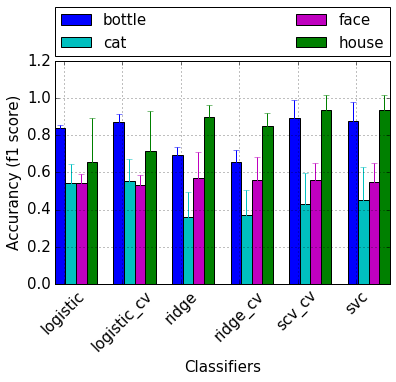

In [6]:
# to see the difference between stimulus category for each classifier 

plt.figure()

ind = np.arange(len(classifiers))
plt.xticks(ind + 0.15, sorted(classifiers.keys()), fontsize=15, rotation=45)
    
for color, category in zip(['b', 'c', 'm', 'g'], categories):
    # list for mean and standard devitations
    mean_list = []
    std_list = []    
    for classifier_name in sorted(classifiers):
        mean_list.append(classifier_mean[classifier_name][category])
        std_list.append(classifier_std[classifier_name][category])
   
    plt.bar(ind, mean_list, label = category, width=.18, color=color, yerr=std_list, ecolor = color)
    ind = ind + 0.18
    
plt.ylabel('Accurancy (f1 score)', fontsize = 15)
plt.xlabel('Classifiers', fontsize = 15)
plt.ylim(ymin=0)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,  fontsize = 15)

plt.yticks(fontsize = 15)
plt.grid()   

plt.savefig('stimulus.png', dpi=300)

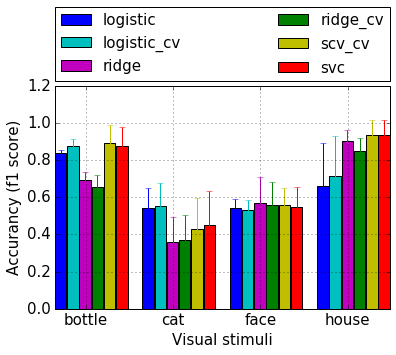

In [7]:
# to see the difference between classifiers for each stimulus category

plt.figure()

ind = np.arange(len(categories))
plt.xticks(ind + 0.35, sorted(categories), fontsize=15)
plt.yticks(fontsize = 15)

for color, classifier_name in zip(
        ['b', 'c', 'm', 'g', 'y', 'r'],
        sorted(classifiers)):
     # list for mean and standard devitations
    mean_list = []
    std_list = []    
    
    for category in categories:
        mean_list.append(classifier_mean[classifier_name][category])
        std_list.append(classifier_std[classifier_name][category]) 
        
     
    plt.bar(ind, mean_list, label = classifier_name, width=.13, color=color, yerr=std_list, ecolor = color)
    ind = ind + 0.14  

plt.ylabel('Accurancy (f1 score)', fontsize = 15)
plt.xlabel('Visual stimuli', fontsize = 15)
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,  fontsize = 15)

plt.grid()

plt.savefig('classifiers.png', dpi=300)

# Step 7: Visualization on MRI Images

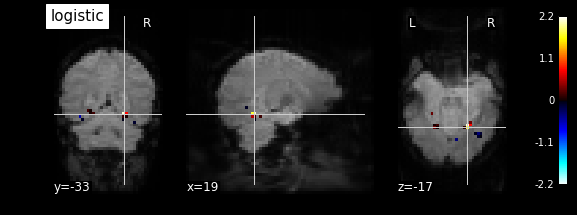

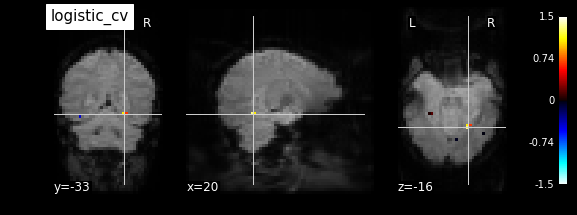

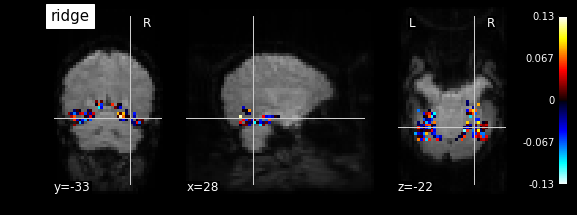

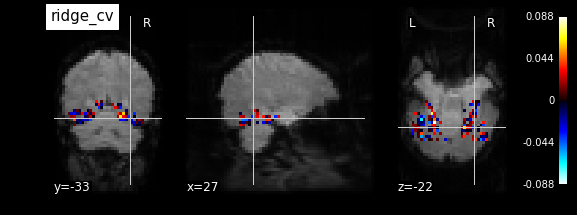

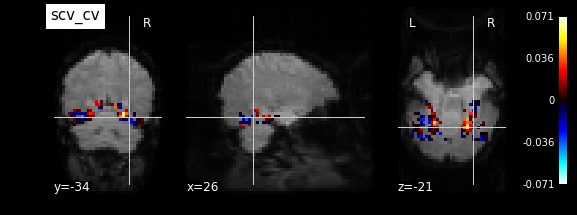

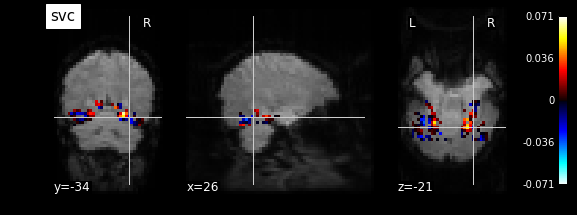

In [8]:
# Use mean EPI image as a background to map on
epi_background = image.mean_img(func_filename)

# Transform the stimuli to binary values
stimulus = stimulus[stimul_mask]
stimulus = (stimulus == b'house').astype(np.int)

for classifier_name, classifier in sorted(classifiers.items()):
    classifier.fit(X, stimulus)

    if hasattr(classifier, 'coef_'):
        weights = classifier.coef_[0]
    elif hasattr(classifier, 'best_estimator_'):
        weights = classifier.best_estimator_.coef_[0]
    else:
        continue
    
    # inverse transform 
    weight_img = nifti_masker.inverse_transform(weights)
    weight_map = weight_img.get_data()
    
    # set a threshold for the weight
    threshold = np.max(np.abs(weight_map)) * 1e-3
    
    # plot the weight on the EPI background images
    plot_stat_map(weight_img, bg_img=epi_background,
                  #output_file='{}.png'.format(classifier_name),
                  display_mode='ortho',
                  threshold=threshold,
                  title='%s' % classifier_name)
plt.show()